# 空間囚人のジレンマの進化シミュレーション

対応する動画：[空間囚人のジレンマゲームの進化シミュレーション　実装編【研究で使うPython #39】](https://youtu.be/IPNtwhR5ySI)

動画のプレイリスト：[研究で使うPython](https://www.youtube.com/playlist?list=PLw5AEs-T7pLHxLaNvGD9tnhrDxAgH-QIw)

## 必要モジュールのインポート

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

## 個体（エージェント）クラスの定義

In [2]:
class Agent:
    def __init__(self, st=None):
        if st is None:
            self.strategy = np.random.choice(['C','D']) # 戦略
        else:
            self.strategy = st
        
        self._n_strategy = None # 近傍個体で最大利得の戦略
        self.color = 1 if self.strategy == 'C' else 0 # 戦略に対応する色
        
        self.reset() # 利得の初期化
        
    # 利得の初期化    
    def reset(self):
        self.payoff = 0.0
    
    # 利得の加算
    def add_payoff(self, p):
        self.payoff += p
    
    # 最大の利得を得た戦略の探索
    def find_n_strategy(self, neighbors):
        max_agent = self
        for i in neighbors:
            if i.payoff > max_agent.payoff:
                max_agent = i
                
        self._n_strategy = max_agent.strategy
    
    
    # 戦略更新
    def update_strategy(self):
        if self.strategy == 'C' and self._n_strategy == 'C':
            self.color = 1  # 青
        elif self.strategy == 'C' and self._n_strategy == 'D':
            self.color = 5  # 黄
        elif self.strategy == 'D' and self._n_strategy == 'C':
            self.color = 2  # 緑
        else:
            self.color = 0  # 赤
            
        self.strategy = self._n_strategy

## シミュレーションクラスの定義

In [3]:
class Simulation:
    def __init__(self, L, T):
        self.R = 1.0 # 利得行列の値
        self.S = 0.0
        self.T = T
        self.P = 0.0
        self.dx = [ -1,1-L,  0,  0, -1,1-L, -1,1-L] # 近傍個体の座標
        self.dy = [  0,  0, -1,1-L,1-L, -1, -1,1-L]
        
        self.pmatrix = {       # 利得行列の辞書表現
            ('C','C'):self.R,
            ('C','D'):self.S,
            ('D','C'):self.T,
            ('D','D'):self.P
        }
        
        self.agentList = self.initialize() # 個体群の生成　CとDをランダムに生成
#        self.agentList = self.initialize(center=True) # 個体群の生成　真ん中だけD
        
    # 個体群の生成
    def initialize(self, center=False):
        agent_list = []   # 個体のリスト
        if not center:
            # L×Lの個体が入ったリストを生成
            agent_list = [[Agent() for i in range(L)] for j in range(L)]
        else:
            agent_list = [[Agent(st='C') for i in range(L)] for j in range(L)]
            agent_list[L//2][L//2].strategy = 'D'
        return agent_list
    
    # 全個体の利得を初期化
    def reset(self):
        # 各個体の利得のリセット処理
        for i in self.agentList:
            for j in i:
                j.reset()
                
                
    # 全ての隣り合った個体間でゲームを実施して利得を与える
    def play_games(self):
        # 二重for文で各個体について処理
        for i,l in enumerate(self.agentList):
            for j,focal in enumerate(l):
                # focal が注目している個体
                # (その座標が (i, j))
                '''
                8近傍の格子であるため，それぞれの個体が
                半分の4個体とゲームをすれば，
                全ての隣り合うエージェント同士で重複なくゲームが実施される
                '''
                for k in range(0, 8, 2):
                    opp = self.agentList[i+self.dy[k]][j+self.dx[k]]
                    p_f = self.pmatrix[(focal.strategy,opp.strategy)]
                    p_o = self.pmatrix[(opp.strategy,focal.strategy)]
                    focal.add_payoff(p_f)
                    opp.add_payoff(p_o)
            
    # 全個体の戦略を同期的に更新させる
    def update_strategies(self):
        # 二重for文で各個体について処理
        for i,l in enumerate(self.agentList):
            for j,focal in enumerate(l):
                # focalが注目している個体
                # (その座標が (i, j) )

                # focalの近傍個体を取得
                neighbors = [self.agentList[i+self.dy[k]][j+self.dx[k]] for k in range(8)]

                # 近傍+自分の中で最も高い利得を持つエージェントを探させる
                # (その戦略をメモさせておく)
                focal.find_n_strategy(neighbors)

        # 全個体についてメモした戦略で更新
        for i in self.agentList:
            for j in i:
                j.update_strategy()



    # 協力者割合を計算して返す
    def calc_C_frequency(self):
        # 協力者人数を数える
        nC = 0
        for i in self.agentList:
            for j in i:
                if j.strategy == 'C':
                    nC += 1

        # 個体総数 (L×L) で割って協力者割合を返す
        return nC / (L**2)  

    
    # 指定された世代数だけ進化させて協力者割合の変化をプロット
    def evolve(self):
        self.reset()             # 利得のリセット
        self.play_games()        # ゲームさせる
        self.update_strategies() # 戦略を更新させる

        # 協力者割合を記録
        fC_list.append(self.calc_C_frequency())


    # アニメーション用のフィールド取得
    def get_field(self):
        return np.array([[i.color for i in lst] for lst in self.agentList])

## シミュレーションの実行

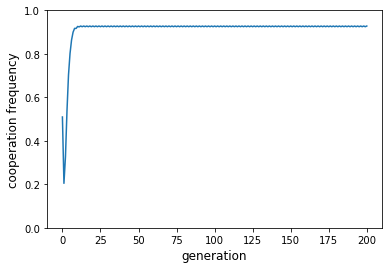

In [4]:
L = 50 # 格子の一辺の長さ
b = 1.10
#b = 1.70

spd = Simulation(L, b)

# 協力者割合を記録
fC_list = [spd.calc_C_frequency()]

Tmax = 200

for t in range(Tmax):
    spd.evolve()
    
       
# 協力者割合の変化をプロット
plt.ylim(0,1)
plt.xlabel('generation', fontsize=12)
plt.ylabel('cooperation frequency', fontsize=12)
plt.plot(fC_list)

## アニメーションクラスの定義（シミュレーションクラスを継承）

In [5]:
class Animation(Simulation):
    def __init__(self, L, T):
        super().__init__(L, T)
        self.fig = plt.figure(figsize=(8,8))
        self.ax = self.fig.add_subplot(111)
        self.ax.axis('off')
        
        self.ims = []
    
    # スナップショット
    def snapshot(self, t):
        im = plt.imshow(self.get_field(), cmap='Set1', 
                   interpolation='none', 
                   vmin=-0.5, vmax=8.5)
        fC = self.calc_C_frequency()
        title = self.ax.text(75, -5, f't={t:3d}, C:{fC:.3f}, D:{1-fC:.3f}')
        self.ims.append([im]+[title])    
    
    # 出力
    def output_animation(self):
        global ani # jupyterでアニメーション表示のためにglobalが必要
        ani = animation.ArtistAnimation(self.fig, self.ims)
        ani.save('./anim_SPD.gif', writer='pillow') 

## アニメーションの実行

In [6]:
%matplotlib nbagg
L = 201
b = 1.65

spd = Animation(L, b)

Tmax = 200
for t in range(Tmax):
    spd.evolve()
    spd.snapshot(t)
    
spd.output_animation()

<IPython.core.display.Javascript object>